# AI Camera DressCode

In [1]:
# Import Libraries
import os
import glob
import yaml
import cv2
import shutil
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

plt.style.use("seaborn-v0_8")

In [2]:
# Load class names
def load_class_names(yaml_path="dataset/data.yaml"):
    with open(yaml_path, "r") as f:
        data = yaml.safe_load(f)
    return data["names"]

In [3]:
# Dataset Paths
splits = {
    "train": "dataset/train/labels",
    "valid": "dataset/valid/labels",
    "test": "dataset/test/labels"
}

image_label_splits = {
    "train": ("dataset/train/images", "dataset/train/labels"),
    "valid": ("dataset/valid/images", "dataset/valid/labels"),
    "test": ("dataset/test/images", "dataset/test/labels")
}

In [4]:
# load classes
class_names = ['Crop_Top', 'Miniskirt', 'Shorts', 'Sleeveless', 'low_neckline', 'ripped_pants', 'normal']
print("✅ Classes Loaded:", class_names)

✅ Classes Loaded: ['Crop_Top', 'Miniskirt', 'Shorts', 'Sleeveless', 'low_neckline', 'ripped_pants', 'normal']


## Data Analysis

In [5]:
# Classes Distribution
def compute_class_distribution(class_names, splits):
    distribution = {split: {cls: 0 for cls in class_names} for split in splits}
    
    for split, label_dir in splits.items():
        for label_file in glob.glob(os.path.join(label_dir, "*.txt")):
            with open(label_file, "r") as f:
                lines = f.readlines()
                if not lines:
                    distribution[split]["normal"] += 1
                else:
                    for line in lines:
                        cls_id = int(line.split()[0])
                        distribution[split][class_names[cls_id]] += 1
    return distribution

In [6]:
# calculate distribution
distribution = compute_class_distribution(class_names, splits)
df = pd.DataFrame(distribution).T
df

,Crop_Top,Miniskirt,Shorts,Sleeveless,low_neckline,ripped_pants,normal
train,309,315,287,710,349,206,120
valid,76,73,49,181,93,110,49
test,54,52,50,119,58,11,20


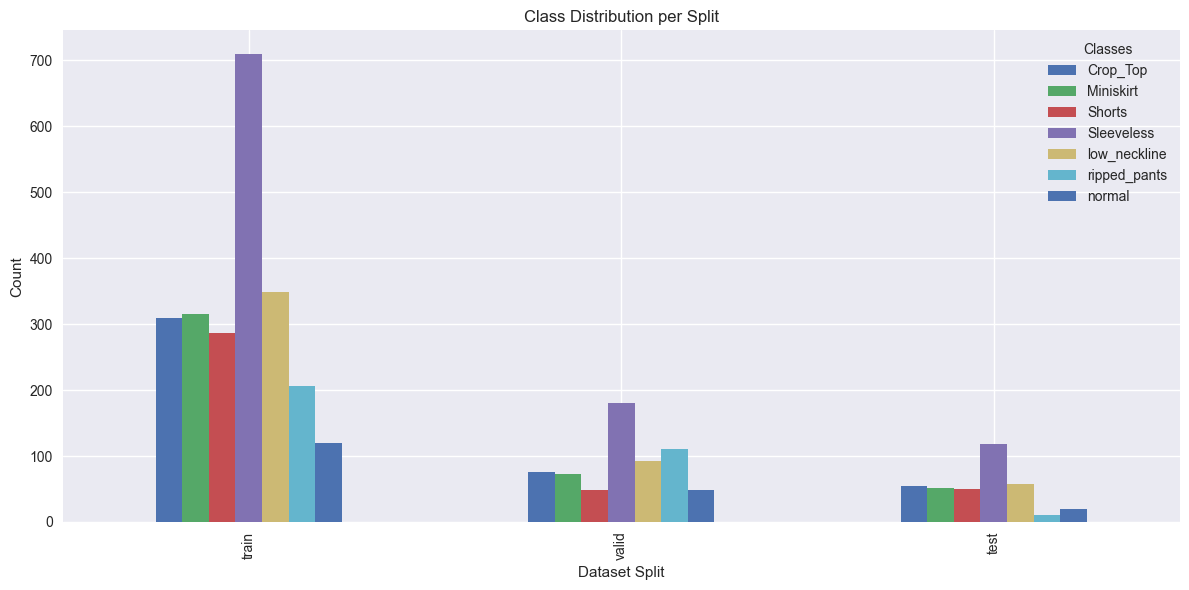

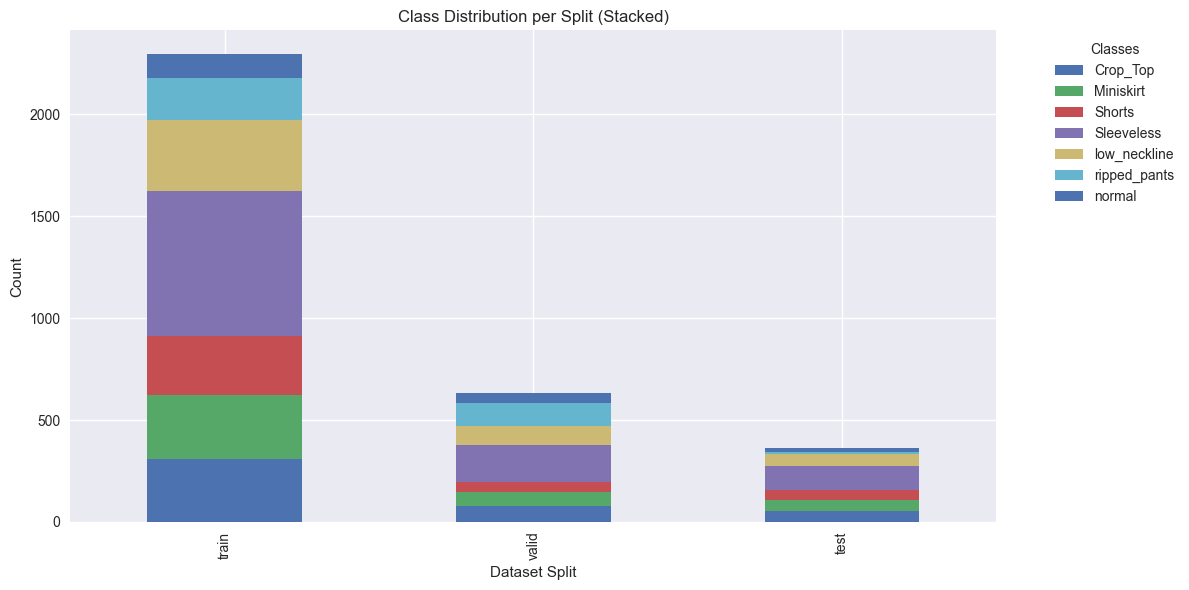

In [7]:
# 4. Plot Class Distribution
def plot_class_distribution(df):
    df.plot(kind="bar", figsize=(12,6))
    plt.title("Class Distribution per Split")
    plt.xlabel("Dataset Split")
    plt.ylabel("Count")
    plt.legend(title="Classes")
    plt.tight_layout()
    plt.show()

    df.plot(kind="bar", stacked=True, figsize=(12,6))
    plt.title("Class Distribution per Split (Stacked)")
    plt.xlabel("Dataset Split")
    plt.ylabel("Count")
    plt.legend(title="Classes", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()
    
plot_class_distribution(df)

In [10]:
# 5. Objects & BBox Stats
def analyze_objects_and_bboxes(splits):
    objects_per_image, bbox_sizes = [], []

    for _, (img_dir, label_dir) in splits.items():
        for label_file in glob.glob(os.path.join(label_dir, "*.txt")):
            img_name = os.path.basename(label_file).replace(".txt", ".jpg")
            img_path = os.path.join(img_dir, img_name)

            img = cv2.imread(img_path)
            if img is None:
                continue
            h, w = img.shape[:2]

            with open(label_file, "r") as f:
                lines = f.readlines()
                objects_per_image.append(len(lines))

                for line in lines:
                    cls, x_center, y_center, bw, bh = map(float, line.strip().split())
                    bbox_area = (bw * w) * (bh * h) / (w * h)
                    bbox_sizes.append(bbox_area)

    return objects_per_image, bbox_sizes
objects_per_image, bbox_sizes = analyze_objects_and_bboxes(image_label_splits)



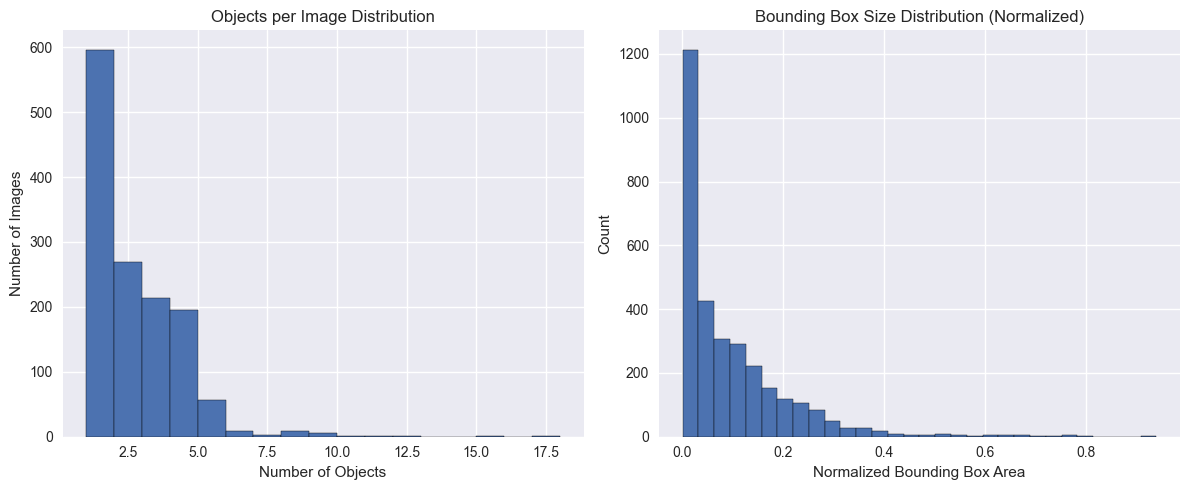

In [11]:
# 6. Plot Objects & BBox Stats
def plot_object_bbox_stats(objects_per_image, bbox_sizes):
    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    plt.hist(objects_per_image, bins=range(1, max(objects_per_image)+2), edgecolor="black")
    plt.title("Objects per Image Distribution")
    plt.xlabel("Number of Objects")
    plt.ylabel("Number of Images")

    plt.subplot(1,2,2)
    plt.hist(bbox_sizes, bins=30, edgecolor="black")
    plt.title("Bounding Box Size Distribution (Normalized)")
    plt.xlabel("Normalized Bounding Box Area")
    plt.ylabel("Count")

    plt.tight_layout()
    plt.show()
plot_object_bbox_stats(objects_per_image, bbox_sizes)

## Preprocessing

In [12]:
# 7. Check Malformed Labels
def check_malformed_labels(lbl_dir):
    print(f"\n🔍 Checking: {lbl_dir}")
    for file in os.listdir(lbl_dir):
        if not file.endswith(".txt"):
            continue
        path = os.path.join(lbl_dir, file)
        with open(path, "r", encoding="utf-8") as f:
            lines = f.readlines()

        for i, line in enumerate(lines, 1):
            if len(line.strip().split()) != 5:
                print(f"⚠️ Malformed line in {file} (line {i}): {line.strip()}")

for _, label_dir in image_label_splits.values():
    check_malformed_labels(label_dir)


🔍 Checking: dataset/train/labels

🔍 Checking: dataset/valid/labels

🔍 Checking: dataset/test/labels


In [13]:
# 8. Convert Polygons → BBoxes
def polygon_to_bbox(points):
    xs, ys = points[::2], points[1::2]
    x_min, x_max, y_min, y_max = min(xs), max(xs), min(ys), max(ys)
    return ( (x_min + x_max) / 2, (y_min + y_max) / 2,
             x_max - x_min, y_max - y_min )

In [14]:
def fix_label_file(path, backup_dir):
    rel_path = os.path.relpath(path, start="dataset")
    backup_path = os.path.join(backup_dir, rel_path)
    os.makedirs(os.path.dirname(backup_path), exist_ok=True)
    shutil.copy(path, backup_path)

    fixed_lines = []
    with open(path, "r", encoding="utf-8") as f:
        for line in f.readlines():
            parts = line.strip().split()
            if len(parts) == 5:
                fixed_lines.append(line.strip())
            elif len(parts) > 5:
                cls, *coords = parts
                coords = list(map(float, coords))
                x, y, w, h = polygon_to_bbox(coords)
                fixed_lines.append(f"{cls} {x:.6f} {y:.6f} {w:.6f} {h:.6f}")

    with open(path, "w", encoding="utf-8") as f:
        f.write("\n".join(fixed_lines))


In [15]:
def process_all_labels():
    backup_dir = "labels_backup"
    os.makedirs(backup_dir, exist_ok=True)

    for split in ["train", "valid", "test"]:
        lbl_dir = f"dataset/{split}/labels"
        for file in os.listdir(lbl_dir):
            if file.endswith(".txt"):
                fix_label_file(os.path.join(lbl_dir, file), backup_dir)
    print("✅ All polygons converted to bounding boxes (backup in labels_backup)")

process_all_labels()

✅ All polygons converted to bounding boxes (backup in labels_backup)


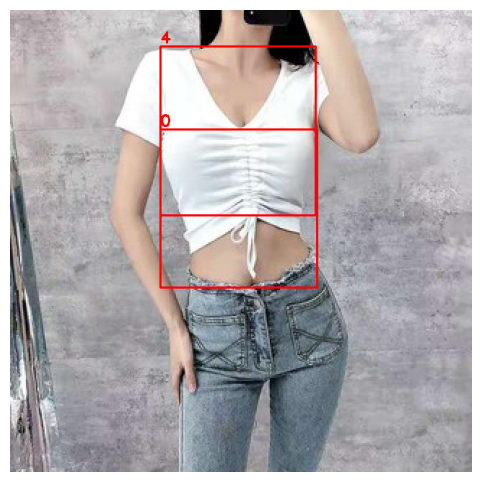

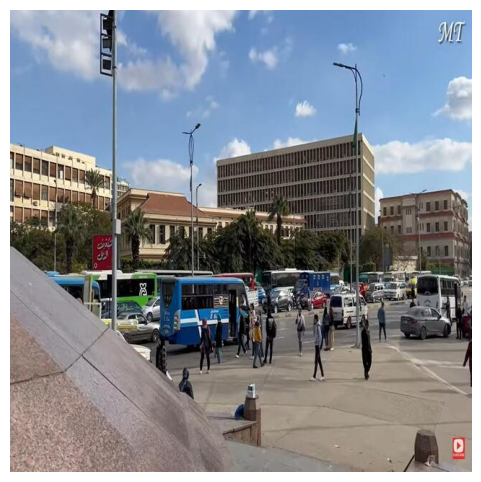

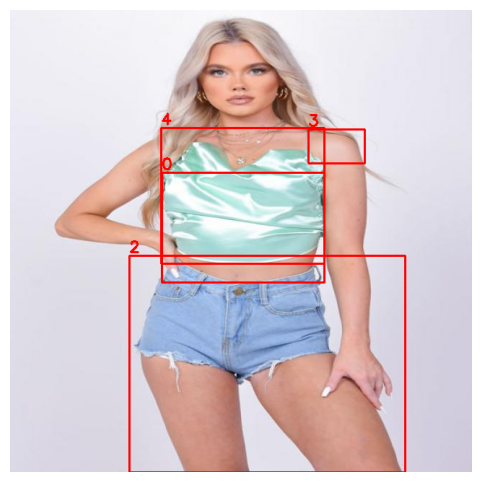

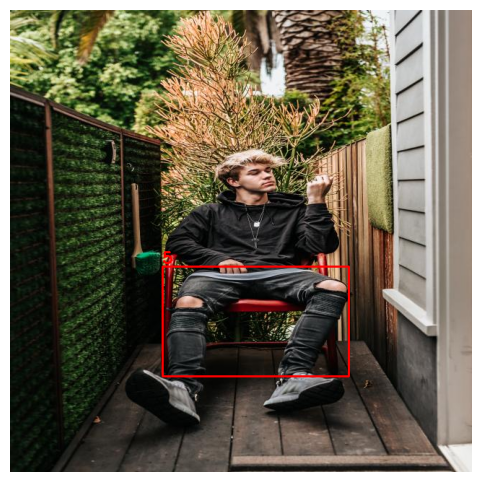

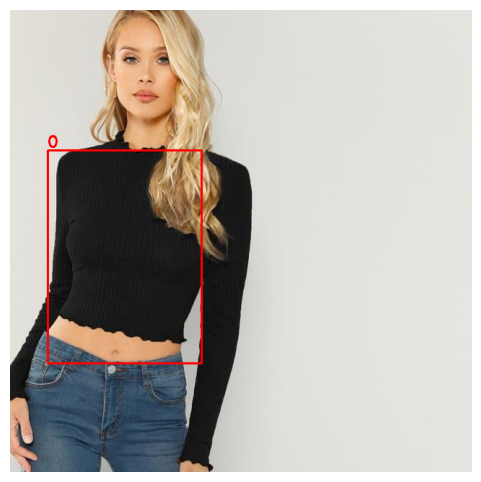

In [16]:
# 9. Visualize Sample Images
def visualize_sample_images(img_dir, label_dir, num_samples=5):
    sample_imgs = random.sample(os.listdir(img_dir), num_samples)

    for img_file in sample_imgs:
        img_path = os.path.join(img_dir, img_file)
        label_path = os.path.join(label_dir, img_file.replace(".jpg", ".txt"))

        img = cv2.imread(img_path)
        if img is None: continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w, _ = img.shape

        if os.path.exists(label_path):
            with open(label_path, "r") as f:
                for line in f.readlines():
                    cls, x, y, bw, bh = map(float, line.strip().split())
                    cls = int(cls)
                    x1, y1 = int((x - bw / 2) * w), int((y - bh / 2) * h)
                    x2, y2 = int((x + bw / 2) * w), int((y + bh / 2) * h)

                    cv2.rectangle(img, (x1, y1), (x2, y2), (255,0,0), 2)
                    cv2.putText(img, str(cls), (x1, y1 - 5),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,0,0), 2)

        plt.figure(figsize=(6,6))
        plt.imshow(img)
        plt.axis("off")
        plt.show()
        
visualize_sample_images("dataset/train/images", "dataset/train/labels", num_samples=5)

In [32]:
#!/usr/bin/env python3
"""
augment_and_rebalance.py

1) Augment images per-class until each class has at least TARGET_PER_CLASS images containing that class.
   Augmented files are written into AUG_DIR (separate from original dataset).
2) Combine originals + AUG_DIR into a pool and create a stratified 80/10/10 split by primary class,
   copying files into dataset_final/{train,valid,test}/images + labels.

Do NOT delete or move originals.
"""
import os
import shutil
import random
import uuid
from pathlib import Path
from collections import Counter, defaultdict

import cv2
import albumentations as A
import yaml

# ---------------- CONFIG ----------------
SRC_ROOT = Path("dataset")              # original dataset (train/valid/test)
AUG_DIR = Path("dataset_augmented")     # where augmented images/labels are saved (keeps originals)
OUT_ROOT = Path("dataset_final")        # final rebalanced dataset (80/10/10) created here
DATA_YAML = SRC_ROOT / "data.yaml"     # try to detect class names from here
TARGET_PER_CLASS = 700                  # desired number of images per class (images containing class)
TRAIN_RATIO = 0.8
VALID_RATIO = 0.1
TEST_RATIO = 0.1
NORMAL_CLASS_ID = 6                     # adjust if 'normal' has a different class id
SEED = 42
IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".webp"}

# Albumentations transform: conservative for clothing imagery
transform = A.Compose([
    A.RandomBrightnessContrast(brightness_limit=0.18, contrast_limit=0.18, p=0.7),
    A.HueSaturationValue(hue_shift_limit=8, sat_shift_limit=12, val_shift_limit=10, p=0.45),
    A.GaussNoise(var_limit=(5.0, 30.0), p=0.25),
    A.MotionBlur(blur_limit=3, p=0.18),
    A.Rotate(limit=6, border_mode=cv2.BORDER_CONSTANT, p=0.35),
    A.RandomScale(scale_limit=0.12, p=0.25),
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels'], min_visibility=0.3))

random.seed(SEED)

# ---------------- utilities ----------------
def load_class_names(yaml_path):
    if not yaml_path.exists():
        return None
    with open(yaml_path, "r", encoding="utf-8") as f:
        data = yaml.safe_load(f)
    names = data.get("names")
    if isinstance(names, dict):
        # sometimes stored as dict {0: name, ...}
        names = [names[i] for i in sorted(names.keys())]
    return names if isinstance(names, list) else None

CLASS_NAMES = load_class_names(DATA_YAML)
if CLASS_NAMES:
    NC = len(CLASS_NAMES)
else:
    # fallback: assume 7 classes and default names if data.yaml missing
    NC = 7
    CLASS_NAMES = [f"class_{i}" for i in range(NC)]

print("Detected classes:", CLASS_NAMES)

def find_all_images_and_labels(src_root: Path):
    """Return list of records with keys: image_path (Path), label_path (Path or None), stem (str)."""
    records = []
    for img_dir in src_root.rglob("images"):
        lbl_dir = img_dir.parent / "labels"
        for img_path in img_dir.iterdir():
            if not img_path.is_file(): continue
            if img_path.suffix.lower() not in IMG_EXTS: continue
            stem = img_path.stem
            lbl_path = lbl_dir / f"{stem}.txt"
            if not lbl_path.exists():
                lbl_path = None
            records.append({"image": img_path, "label": lbl_path, "stem": stem})
    return records

def read_label_classes(label_path):
    """Return list of class ids (ints) present in label file. If None or empty -> return []"""
    if label_path is None:
        return []
    try:
        with open(label_path, "r", encoding="utf-8") as f:
            lines = [ln.strip() for ln in f if ln.strip()]
    except Exception:
        return []
    cls = []
    for ln in lines:
        parts = ln.split()
        if len(parts) < 1: continue
        try:
            cid = int(float(parts[0]))
            cls.append(cid)
        except Exception:
            continue
    return cls

def images_containing_class(records, class_id):
    """Return list of image records that include class_id at least once."""
    return [r for r in records if class_id in read_label_classes(r["label"])]

def count_images_per_class(records):
    """Return dict class_id -> number of images containing that class."""
    cnt = Counter()
    for r in records:
        classes = set(read_label_classes(r["label"]))
        if not classes:
            # treat empty label as normal class occurrence (optional)
            classes = {NORMAL_CLASS_ID}
        for c in classes:
            cnt[c] += 1
    return cnt

# ---------------- augmentation ----------------
def ensure_aug_dirs():
    (AUG_DIR / "images").mkdir(parents=True, exist_ok=True)
    (AUG_DIR / "labels").mkdir(parents=True, exist_ok=True)

def augment_until_target(records, target_per_class=TARGET_PER_CLASS, max_attempts_per_source=5):
    """
    records: list of original image records (originals only)
    Augment images per class until image count per class >= target_per_class.
    Augmented files saved into AUG_DIR and returned new records will be appended to pool.
    """
    ensure_aug_dirs()
    # Start pool as originals
    pool = list(records)
    # compute current counts based on pool
    counts = count_images_per_class(pool)
    print("Initial counts per class:", counts)

    # For each class, augment if needed
    for class_id in range(NC):
        current = counts.get(class_id, 0)
        if current >= target_per_class:
            print(f"Class {class_id} ({CLASS_NAMES[class_id]}): {current} images (>= target {target_per_class}) - skip augmentation.")
            continue
        print(f"\n=== Augmenting class {class_id} ({CLASS_NAMES[class_id]}): {current} -> {target_per_class} images ===")
        # source images that contain this class (originals only, not newly augmented)
        sources = images_containing_class(records, class_id)
        if not sources:
            print(f"⚠ No source images contain class {class_id}. Cannot augment this class.")
            continue

        # Loop until count >= target_per_class
        src_index = 0
        attempts = 0
        while current < target_per_class:
            # pick next source image (round robin)
            src = sources[src_index % len(sources)]
            src_index += 1
            attempts += 1
            if attempts > len(sources) * max_attempts_per_source and current < target_per_class:
                print("⚠ Too many failed augmentation attempts. Consider increasing max_attempts_per_source or lowering min_visibility.")
                break

            img_path = src["image"]
            lbl_path = src["label"]
            img = cv2.imread(str(img_path))
            if img is None:
                continue
            # load original bboxes and labels
            bboxes = []
            class_labels = []
            if lbl_path:
                try:
                    with open(lbl_path, "r", encoding="utf-8") as f:
                        for line in f:
                            parts = line.strip().split()
                            if len(parts) != 5:
                                continue
                            cid = int(float(parts[0])); x, y, bw, bh = map(float, parts[1:])
                            bboxes.append([x, y, bw, bh])
                            class_labels.append(cid)
                except Exception:
                    continue
            else:
                # no labels -> treat as normal only
                bboxes = []
                class_labels = []

            # Apply augmentation
            try:
                augmented = transform(image=img, bboxes=bboxes, class_labels=class_labels)
            except Exception as e:
                # augmentation sometimes fails for some inputs, skip
                continue

            aug_img = augmented['image']
            aug_bboxes = augmented['bboxes']
            aug_labels = augmented['class_labels']

            # keep only augmentations where target class remains present
            if not any(int(c) == class_id for c in aug_labels):
                continue

            # save augmented image & label with unique name
            uid = uuid.uuid4().hex[:8]
            new_img_name = f"{img_path.stem}_aug_{class_id}_{uid}.jpg"
            new_lbl_name = f"{img_path.stem}_aug_{class_id}_{uid}.txt"
            out_img_path = AUG_DIR / "images" / new_img_name
            out_lbl_path = AUG_DIR / "labels" / new_lbl_name

            try:
                cv2.imwrite(str(out_img_path), aug_img)
                with open(out_lbl_path, "w", encoding="utf-8") as f:
                    for cid, bb in zip(aug_labels, aug_bboxes):
                        # ensure bb has 4 values
                        if len(bb) != 4:
                            continue
                        x, y, bw, bh = bb
                        f.write(f"{int(cid)} {x:.6f} {y:.6f} {bw:.6f} {bh:.6f}\n")
            except Exception as e:
                # saving failed
                print("⚠ Failed to save augmentation:", e)
                continue

            # add new record to pool and update counts
            new_rec = {"image": out_img_path, "label": out_lbl_path, "stem": out_img_path.stem}
            pool.append(new_rec)
            # if augmented image includes multiple classes, increase counts accordingly (we count images per class once even if multiple instances)
            classes_in_aug = set(int(c) for c in aug_labels) if aug_labels else {NORMAL_CLASS_ID}
            for c in classes_in_aug:
                counts[c] = counts.get(c, 0) + 1
            current = counts.get(class_id, 0)
            if current % 10 == 0 or current == target_per_class:
                print(f"  progress class {class_id}: {current}/{target_per_class}")
        print(f"Finished augmenting class {class_id}. final count: {counts.get(class_id,0)}")

    print("\nAll augmentation done. Final counts per class:", counts)
    return pool, counts

# ---------------- stratified split ----------------
def primary_class_for_record(record):
    """Return primary class id for an image record (most frequent class in label)."""
    cls_list = read_label_classes(record["label"])
    if not cls_list:
        return NORMAL_CLASS_ID
    counts = Counter(cls_list)
    primary = sorted(counts.items(), key=lambda kv: (-kv[1], kv[0]))[0][0]
    return primary

def stratified_split_and_copy(pool_records, out_root=OUT_ROOT, train_ratio=TRAIN_RATIO, valid_ratio=VALID_RATIO, test_ratio=TEST_RATIO):
    """
    pool_records: list of records (Path objects for image and label)
    Create stratified split by primary_class and copy files into out_root/<split>/(images|labels)
    """
    # compute primary class per record
    for r in pool_records:
        r['primary'] = primary_class_for_record(r)

    # group by primary
    by_class = defaultdict(list)
    for r in pool_records:
        by_class[r['primary']].append(r)

    # create splits
    splits = {'train': [], 'valid': [], 'test': []}
    random.seed(SEED)
    for cls, recs in by_class.items():
        random.shuffle(recs)
        n = len(recs)
        n_train = int(n * train_ratio)
        n_valid = int(n * valid_ratio)
        n_test = n - n_train - n_valid
        splits['train'].extend(recs[:n_train])
        splits['valid'].extend(recs[n_train:n_train + n_valid])
        splits['test'].extend(recs[n_train + n_valid:])

    # shuffle
    for k in splits:
        random.shuffle(splits[k])

    # prepare out directories
    for split in ['train', 'valid', 'test']:
        (out_root / split / "images").mkdir(parents=True, exist_ok=True)
        (out_root / split / "labels").mkdir(parents=True, exist_ok=True)

    # copy files
    for split, recs in splits.items():
        for r in recs:
            src_img = Path(r['image'])
            src_lbl = Path(r['label']) if r['label'] else None
            dst_img = out_root / split / "images" / src_img.name
            dst_lbl = out_root / split / "labels" / (src_img.stem + ".txt")
            # copy image
            shutil.copy2(src_img, dst_img)
            # copy or create empty label
            if src_lbl and src_lbl.exists():
                shutil.copy2(src_lbl, dst_lbl)
            else:
                dst_lbl.write_text("", encoding="utf-8")

    # Print stats
    print("\n--- Final split stats ---")
    for split in ['train', 'valid', 'test']:
        recs = splits[split]
        print(f"{split}: images={len(recs)}")
        # per-class distribution
        cls_count = Counter([r['primary'] for r in recs])
        print(f" per-class counts: {dict(cls_count)}")
    print(f"\nFinal dataset written to: {out_root}")

# ---------------- main process ----------------
def main():
    print("Scanning original dataset for images and labels...")
    orig_records = find_all_images_and_labels(SRC_ROOT)
    print(f"Found {len(orig_records)} original images in {SRC_ROOT}")

    # Augment per class until target achieved (augmented files saved to AUG_DIR)
    pool, final_counts = augment_until_target(orig_records, TARGET_PER_CLASS)

    # Pool now contains originals + augmented images
    print(f"Total pool size after augmentation: {len(pool)} images")

    # Stratified split and copy to OUT_ROOT
    if OUT_ROOT.exists():
        print(f"Warning: {OUT_ROOT} already exists, files may be overwritten inside.")
    stratified_split_and_copy(pool, out_root=OUT_ROOT)
    print("All done.")

if __name__ == "__main__":
    main()


C:\Users\Lorcan Floran\AppData\Local\Temp\ipykernel_7864\2493791178.py:40: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(5.0, 30.0), p=0.25),


Detected classes: ['Crop_Top', 'Miniskirt', 'Shorts', 'Sleeveless', 'low_neckline', 'ripped_pants']
Scanning original dataset for images and labels...
Found 1726 original images in dataset
Initial counts per class: Counter({3: 642, 4: 517, 1: 467, 0: 453, 2: 367, 5: 363, 6: 202})

=== Augmenting class 0 (Crop_Top): 453 -> 700 images ===
  progress class 0: 460/700
  progress class 0: 470/700
  progress class 0: 480/700
  progress class 0: 490/700
  progress class 0: 500/700
  progress class 0: 510/700
  progress class 0: 520/700
  progress class 0: 530/700
  progress class 0: 540/700
  progress class 0: 550/700
  progress class 0: 560/700
  progress class 0: 570/700
  progress class 0: 580/700
  progress class 0: 590/700
  progress class 0: 600/700
  progress class 0: 610/700
  progress class 0: 620/700
  progress class 0: 630/700
  progress class 0: 640/700
  progress class 0: 650/700
  progress class 0: 660/700
  progress class 0: 670/700
  progress class 0: 680/700
  progress class 

In [18]:
from ultralytics import YOLO
model = YOLO("yolov8n.pt")

model.train(data="dataset\data.yaml", epochs=100, imgsz=640, batch=16, name="dresscode_baseline")


New https://pypi.org/project/ultralytics/8.3.191 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.140  Python-3.10.11 torch-2.7.0+cu118 CUDA:0 (NVIDIA GeForce RTX 3070 Ti, 8192MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset\data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=dresscode_baseline2, nbs=64, nms=False, opset=

train: Scanning C:\Users\Lorcan Floran\Downloads\AI-Camera-DressCode-main_2\AI-Camera-DressCode-main\dataset\train\labels.cache... 1071 images, 120 backgrounds, 0 corrupt: 100%|██████████| 1071/1071 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.20.3 ms, read: 218.9134.0 MB/s, size: 49.2 KB)


val: Scanning C:\Users\Lorcan Floran\Downloads\AI-Camera-DressCode-main_2\AI-Camera-DressCode-main\dataset\valid\labels.cache... 324 images, 49 backgrounds, 0 corrupt: 100%|██████████| 324/324 [00:00<?, ?it/s]


Plotting labels to runs\detect\dresscode_baseline2\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\dresscode_baseline2
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      2.87G      1.478      3.499      1.676         44        640: 100%|██████████| 67/67 [00:08<00:00,  7.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.61it/s]

                   all        324        582      0.738     0.0349      0.245      0.136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      2.87G      1.377      2.481      1.525         50        640: 100%|██████████| 67/67 [00:07<00:00,  9.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  7.16it/s]

                   all        324        582       0.45      0.524      0.448      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.87G       1.36      2.224      1.497         59        640: 100%|██████████| 67/67 [00:06<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  7.12it/s]

                   all        324        582      0.531      0.471      0.507      0.306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.87G      1.373      2.139      1.499         66        640: 100%|██████████| 67/67 [00:06<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  7.22it/s]

                   all        324        582      0.435      0.496      0.452      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      2.87G      1.324       1.99      1.464         48        640: 100%|██████████| 67/67 [00:07<00:00,  9.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.81it/s]

                   all        324        582      0.565      0.551      0.581      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.87G      1.297      1.873      1.432         53        640: 100%|██████████| 67/67 [00:07<00:00,  8.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.38it/s]

                   all        324        582      0.618      0.617       0.64      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.87G      1.284      1.754      1.411         59        640: 100%|██████████| 67/67 [00:07<00:00,  8.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.72it/s]

                   all        324        582      0.669      0.567       0.67      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.87G      1.263      1.732      1.398         47        640: 100%|██████████| 67/67 [00:08<00:00,  8.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.98it/s]

                   all        324        582      0.646      0.633      0.682      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.87G      1.261      1.646      1.402         42        640: 100%|██████████| 67/67 [00:08<00:00,  8.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.26it/s]

                   all        324        582      0.642      0.633       0.66      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.87G      1.199      1.533      1.354         56        640: 100%|██████████| 67/67 [00:08<00:00,  7.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.44it/s]

                   all        324        582      0.671      0.664      0.729      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.87G      1.223      1.497      1.353         53        640: 100%|██████████| 67/67 [00:08<00:00,  8.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.43it/s]

                   all        324        582      0.715      0.635      0.699      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.87G      1.211      1.491      1.353         77        640: 100%|██████████| 67/67 [00:07<00:00,  8.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.86it/s]

                   all        324        582       0.74      0.687      0.759      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.87G      1.167      1.444      1.326         36        640: 100%|██████████| 67/67 [00:07<00:00,  9.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.57it/s]

                   all        324        582      0.666      0.655      0.719      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      2.87G      1.173      1.348      1.311         34        640: 100%|██████████| 67/67 [00:07<00:00,  8.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.99it/s]

                   all        324        582      0.679      0.725      0.762      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.87G      1.165      1.392      1.317         41        640: 100%|██████████| 67/67 [00:07<00:00,  8.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.67it/s]

                   all        324        582      0.737      0.668      0.743      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.87G      1.149      1.374      1.304         55        640: 100%|██████████| 67/67 [00:07<00:00,  8.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.50it/s]

                   all        324        582      0.741      0.654      0.708      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      2.87G      1.145      1.341      1.311         37        640: 100%|██████████| 67/67 [00:07<00:00,  8.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.83it/s]

                   all        324        582      0.721      0.729      0.766      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.87G      1.127       1.31      1.299         44        640: 100%|██████████| 67/67 [00:07<00:00,  8.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.60it/s]

                   all        324        582      0.747      0.705       0.76      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.87G      1.117      1.274      1.295         38        640: 100%|██████████| 67/67 [00:07<00:00,  8.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  7.25it/s]

                   all        324        582      0.678      0.766      0.772      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.87G      1.103      1.256      1.284         65        640: 100%|██████████| 67/67 [00:07<00:00,  8.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  7.30it/s]

                   all        324        582      0.747      0.753      0.799      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.87G      1.106      1.255      1.289         57        640: 100%|██████████| 67/67 [00:07<00:00,  9.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.98it/s]

                   all        324        582      0.724      0.688      0.766       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.87G       1.08      1.228      1.278         71        640: 100%|██████████| 67/67 [00:07<00:00,  8.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.83it/s]

                   all        324        582      0.679      0.721      0.788      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      2.87G       1.07       1.18      1.261         50        640: 100%|██████████| 67/67 [00:07<00:00,  8.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.70it/s]

                   all        324        582      0.791      0.693      0.792      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      2.87G       1.07      1.183      1.262         61        640: 100%|██████████| 67/67 [00:07<00:00,  8.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.54it/s]

                   all        324        582      0.756       0.76      0.816      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      2.87G      1.075      1.193      1.267         60        640: 100%|██████████| 67/67 [00:07<00:00,  8.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.73it/s]

                   all        324        582      0.722      0.739      0.776      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      2.87G      1.064      1.119      1.248         62        640: 100%|██████████| 67/67 [00:08<00:00,  7.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.55it/s]

                   all        324        582      0.793       0.68      0.789      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      2.87G       1.05      1.131      1.241         49        640: 100%|██████████| 67/67 [00:08<00:00,  8.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.78it/s]

                   all        324        582      0.762      0.757      0.807      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      2.87G      1.017      1.077       1.21         58        640: 100%|██████████| 67/67 [00:08<00:00,  8.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.70it/s]

                   all        324        582      0.799      0.732      0.801      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.87G      1.002      1.089      1.206         42        640: 100%|██████████| 67/67 [00:07<00:00,  8.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.76it/s]

                   all        324        582       0.81       0.73      0.807      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      2.87G      1.012      1.058       1.21         44        640: 100%|██████████| 67/67 [00:07<00:00,  8.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.59it/s]

                   all        324        582       0.74      0.752      0.795      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      2.87G      1.012      1.069      1.224         43        640: 100%|██████████| 67/67 [00:07<00:00,  8.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.50it/s]

                   all        324        582      0.784      0.774      0.816      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      2.87G       1.01      1.054      1.213         37        640: 100%|██████████| 67/67 [00:07<00:00,  8.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.88it/s]

                   all        324        582      0.789      0.743      0.805      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      2.87G      1.006      1.046       1.21         42        640: 100%|██████████| 67/67 [00:07<00:00,  8.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.54it/s]

                   all        324        582      0.788      0.767      0.809      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      2.87G     0.9684      1.002      1.189         45        640: 100%|██████████| 67/67 [00:08<00:00,  8.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.49it/s]

                   all        324        582      0.805      0.768      0.814      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      2.87G     0.9961      1.007      1.194         49        640: 100%|██████████| 67/67 [00:07<00:00,  8.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  7.02it/s]

                   all        324        582      0.783      0.722        0.8      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      2.87G     0.9685      0.991      1.177         55        640: 100%|██████████| 67/67 [00:07<00:00,  8.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.96it/s]

                   all        324        582       0.81      0.706      0.794      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      2.87G     0.9611     0.9856      1.181         66        640: 100%|██████████| 67/67 [00:07<00:00,  9.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  7.09it/s]

                   all        324        582      0.759      0.765      0.801      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      2.87G     0.9535     0.9505      1.168         62        640: 100%|██████████| 67/67 [00:07<00:00,  8.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.54it/s]

                   all        324        582      0.752      0.772      0.808      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      2.87G     0.9624     0.9433      1.172         44        640: 100%|██████████| 67/67 [00:08<00:00,  8.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.74it/s]

                   all        324        582      0.785      0.756      0.802      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      2.87G     0.9632     0.9546      1.183         59        640: 100%|██████████| 67/67 [00:07<00:00,  9.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.71it/s]

                   all        324        582      0.799      0.797      0.824      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      2.87G     0.9596     0.9507      1.178         44        640: 100%|██████████| 67/67 [00:07<00:00,  8.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.98it/s]

                   all        324        582      0.827      0.733       0.81      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      2.87G     0.9331     0.9416      1.168         56        640: 100%|██████████| 67/67 [00:07<00:00,  8.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.54it/s]

                   all        324        582      0.755      0.766      0.811      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      2.87G     0.9406     0.9154      1.167         47        640: 100%|██████████| 67/67 [00:07<00:00,  8.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  7.42it/s]

                   all        324        582      0.795      0.801      0.832      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      2.87G     0.9255     0.9113      1.159         54        640: 100%|██████████| 67/67 [00:07<00:00,  8.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.55it/s]

                   all        324        582      0.763      0.764      0.799      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      2.87G     0.9223     0.8771      1.151         60        640: 100%|██████████| 67/67 [00:07<00:00,  8.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.63it/s]

                   all        324        582        0.8      0.763      0.815      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      2.87G     0.9018     0.8586      1.141         58        640: 100%|██████████| 67/67 [00:07<00:00,  8.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.02it/s]

                   all        324        582      0.796      0.785       0.83      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      2.87G     0.9094     0.8851       1.15         59        640: 100%|██████████| 67/67 [00:07<00:00,  8.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.77it/s]

                   all        324        582      0.786      0.743      0.805      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      2.87G     0.9078     0.8588      1.148         42        640: 100%|██████████| 67/67 [00:07<00:00,  8.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.82it/s]

                   all        324        582       0.78      0.746      0.813      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      2.87G     0.9026     0.8579      1.144         56        640: 100%|██████████| 67/67 [00:07<00:00,  8.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.88it/s]

                   all        324        582      0.802       0.77      0.827       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      2.87G     0.9151     0.8779      1.153         44        640: 100%|██████████| 67/67 [00:07<00:00,  9.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  7.07it/s]

                   all        324        582      0.748      0.814      0.817      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      2.87G     0.8979     0.8415      1.141         54        640: 100%|██████████| 67/67 [00:07<00:00,  8.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.57it/s]

                   all        324        582      0.787      0.758      0.809      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      2.87G     0.8916     0.8567      1.142         48        640: 100%|██████████| 67/67 [00:07<00:00,  8.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.92it/s]

                   all        324        582      0.777      0.777       0.83      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      2.87G     0.8677     0.8169      1.117         46        640: 100%|██████████| 67/67 [00:07<00:00,  8.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  7.01it/s]

                   all        324        582      0.829       0.76      0.836      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      2.87G     0.8528      0.816      1.115         61        640: 100%|██████████| 67/67 [00:07<00:00,  8.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.51it/s]

                   all        324        582      0.793       0.77      0.802       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      2.87G     0.8739     0.8154      1.126         62        640: 100%|██████████| 67/67 [00:08<00:00,  8.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.58it/s]

                   all        324        582      0.798       0.74      0.809      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      2.87G     0.8665     0.8109      1.124         66        640: 100%|██████████| 67/67 [00:07<00:00,  8.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.53it/s]

                   all        324        582       0.83      0.781      0.832      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      2.87G     0.8542     0.7827      1.118         57        640: 100%|██████████| 67/67 [00:07<00:00,  8.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.97it/s]

                   all        324        582      0.829      0.782      0.839      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      2.87G     0.8442     0.7727      1.116         50        640: 100%|██████████| 67/67 [00:07<00:00,  8.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.73it/s]

                   all        324        582      0.807      0.796      0.832      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      2.87G     0.8616     0.7841      1.107         46        640: 100%|██████████| 67/67 [00:07<00:00,  8.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.97it/s]

                   all        324        582      0.793      0.787      0.822      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      2.87G     0.8464     0.7661      1.113         64        640: 100%|██████████| 67/67 [00:07<00:00,  8.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.82it/s]

                   all        324        582      0.803      0.793      0.823      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      2.87G     0.8438     0.7828      1.111         47        640: 100%|██████████| 67/67 [00:07<00:00,  8.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  7.02it/s]

                   all        324        582      0.822      0.774      0.832      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      2.87G     0.8366     0.7677      1.114         30        640: 100%|██████████| 67/67 [00:07<00:00,  8.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.49it/s]

                   all        324        582      0.802       0.78      0.827      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      2.87G     0.8376     0.7551      1.105         55        640: 100%|██████████| 67/67 [00:07<00:00,  8.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.73it/s]

                   all        324        582      0.811      0.772      0.824      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      2.87G     0.8252     0.7587      1.097         52        640: 100%|██████████| 67/67 [00:07<00:00,  8.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.76it/s]

                   all        324        582      0.808      0.752      0.814      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      2.87G     0.8114     0.7312      1.092         41        640: 100%|██████████| 67/67 [00:08<00:00,  8.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.39it/s]

                   all        324        582      0.814      0.786      0.828      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      2.87G     0.8108     0.7259      1.087         55        640: 100%|██████████| 67/67 [00:07<00:00,  8.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  7.17it/s]

                   all        324        582      0.811      0.773      0.824      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      2.87G     0.8254     0.7458      1.086         46        640: 100%|██████████| 67/67 [00:07<00:00,  9.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  7.29it/s]

                   all        324        582      0.763      0.768      0.812      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      2.87G     0.7962     0.7067      1.082         55        640: 100%|██████████| 67/67 [00:07<00:00,  9.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.92it/s]

                   all        324        582       0.79      0.783       0.82      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      2.87G      0.815     0.7114      1.101         62        640: 100%|██████████| 67/67 [00:07<00:00,  8.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  7.18it/s]

                   all        324        582      0.796      0.817      0.835      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      2.87G     0.8089     0.7191      1.086         46        640: 100%|██████████| 67/67 [00:07<00:00,  8.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  7.03it/s]

                   all        324        582      0.797      0.791      0.827      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      2.87G     0.7959     0.6873      1.081         50        640: 100%|██████████| 67/67 [00:07<00:00,  9.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  7.03it/s]

                   all        324        582      0.808      0.771      0.833      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      2.87G      0.787     0.6771      1.071         50        640: 100%|██████████| 67/67 [00:07<00:00,  9.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.95it/s]

                   all        324        582      0.823      0.763      0.833      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      2.87G     0.7951     0.7116      1.073         49        640: 100%|██████████| 67/67 [00:07<00:00,  9.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  7.00it/s]

                   all        324        582      0.773      0.797      0.831      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      2.87G     0.7776     0.6847      1.069         37        640: 100%|██████████| 67/67 [00:07<00:00,  8.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  7.10it/s]

                   all        324        582      0.789      0.778      0.832      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      2.87G     0.7874      0.694       1.07         45        640: 100%|██████████| 67/67 [00:07<00:00,  9.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.93it/s]

                   all        324        582      0.839      0.739      0.823      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      2.87G     0.7517     0.6688      1.059         57        640: 100%|██████████| 67/67 [00:07<00:00,  8.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  7.26it/s]

                   all        324        582      0.805      0.782      0.836      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      2.87G     0.7867     0.6708       1.07         41        640: 100%|██████████| 67/67 [00:07<00:00,  8.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  7.03it/s]

                   all        324        582      0.832      0.769      0.834      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      2.87G     0.7681      0.664      1.062         33        640: 100%|██████████| 67/67 [00:07<00:00,  8.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  7.01it/s]

                   all        324        582       0.81      0.771      0.834      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      2.87G     0.7456     0.6448      1.059         58        640: 100%|██████████| 67/67 [00:07<00:00,  8.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.84it/s]

                   all        324        582       0.78      0.768      0.821      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      2.87G     0.7502     0.6348      1.053         53        640: 100%|██████████| 67/67 [00:08<00:00,  7.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.72it/s]

                   all        324        582      0.816      0.752      0.826       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      2.87G     0.7614     0.6564      1.062         62        640: 100%|██████████| 67/67 [00:08<00:00,  8.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  7.29it/s]

                   all        324        582      0.806      0.782       0.83        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      2.87G       0.74     0.6315      1.052         66        640: 100%|██████████| 67/67 [00:07<00:00,  9.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.70it/s]

                   all        324        582       0.81      0.805      0.838      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      2.87G     0.7438     0.6313       1.05         45        640: 100%|██████████| 67/67 [00:07<00:00,  8.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.47it/s]

                   all        324        582      0.823      0.778      0.842      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      2.87G     0.7395     0.6288       1.05         57        640: 100%|██████████| 67/67 [00:08<00:00,  8.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.78it/s]

                   all        324        582      0.824      0.779       0.83      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      2.87G     0.7427     0.6237      1.045         59        640: 100%|██████████| 67/67 [00:08<00:00,  8.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.66it/s]

                   all        324        582      0.841       0.78      0.843      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      2.87G      0.733     0.6165       1.04         41        640: 100%|██████████| 67/67 [00:08<00:00,  8.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.65it/s]

                   all        324        582      0.805      0.773       0.83      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      2.87G     0.7365     0.6421      1.045         72        640: 100%|██████████| 67/67 [00:08<00:00,  8.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.63it/s]

                   all        324        582      0.809      0.774      0.828      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      2.87G     0.7136     0.6028      1.023         44        640: 100%|██████████| 67/67 [00:08<00:00,  7.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.48it/s]

                   all        324        582      0.797        0.8      0.837      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      2.87G     0.7098     0.5974      1.037         53        640: 100%|██████████| 67/67 [00:07<00:00,  8.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.86it/s]

                   all        324        582      0.805      0.777      0.832      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      2.87G     0.7002     0.5929      1.024         49        640: 100%|██████████| 67/67 [00:07<00:00,  9.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  7.25it/s]

                   all        324        582      0.772       0.83      0.837      0.597


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      2.87G     0.6714     0.5029     0.9923         39        640: 100%|██████████| 67/67 [00:07<00:00,  9.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.99it/s]

                   all        324        582      0.857      0.751      0.834      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      2.87G     0.6459     0.4669     0.9864         27        640: 100%|██████████| 67/67 [00:07<00:00,  9.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.22it/s]

                   all        324        582      0.801      0.795      0.835      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      2.87G     0.6407     0.4595     0.9856         22        640: 100%|██████████| 67/67 [00:08<00:00,  7.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.39it/s]

                   all        324        582      0.807      0.796      0.844      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      2.87G     0.6241     0.4556     0.9764         36        640: 100%|██████████| 67/67 [00:08<00:00,  8.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.87it/s]

                   all        324        582      0.764      0.826      0.842      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      2.87G     0.6293     0.4479     0.9785         27        640: 100%|██████████| 67/67 [00:07<00:00,  8.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.00it/s]

                   all        324        582      0.791      0.808      0.838      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      2.87G     0.6206     0.4434     0.9697         26        640: 100%|██████████| 67/67 [00:08<00:00,  8.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.90it/s]

                   all        324        582      0.795      0.824      0.839      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      2.87G     0.6156     0.4439     0.9713         23        640: 100%|██████████| 67/67 [00:08<00:00,  8.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.73it/s]

                   all        324        582      0.788      0.811      0.834      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      2.87G     0.6162     0.4315      0.966         36        640: 100%|██████████| 67/67 [00:07<00:00,  9.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  7.36it/s]

                   all        324        582      0.788        0.8      0.832      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      2.87G     0.6089     0.4299     0.9641         37        640: 100%|██████████| 67/67 [00:07<00:00,  9.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.97it/s]

                   all        324        582      0.785      0.808      0.833      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      2.87G     0.6052     0.4359     0.9675         44        640: 100%|██████████| 67/67 [00:07<00:00,  9.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  7.17it/s]

                   all        324        582      0.797      0.787      0.832      0.603



100 epochs completed in 0.274 hours.
Optimizer stripped from runs\detect\dresscode_baseline2\weights\last.pt, 6.3MB
Optimizer stripped from runs\detect\dresscode_baseline2\weights\best.pt, 6.3MB

Validating runs\detect\dresscode_baseline2\weights\best.pt...
Ultralytics 8.3.140  Python-3.10.11 torch-2.7.0+cu118 CUDA:0 (NVIDIA GeForce RTX 3070 Ti, 8192MiB)
Model summary (fused): 72 layers, 3,006,818 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.33it/s]


                   all        324        582      0.804      0.797      0.835      0.608
              Crop_Top         67         76      0.785      0.803      0.833      0.619
             Miniskirt         71         73       0.79      0.836       0.86        0.7
                Shorts         43         49      0.788      0.834      0.858      0.715
            Sleeveless        107        181      0.757      0.653      0.706        0.3
          low_neckline         84         93      0.781      0.828       0.83      0.609
          ripped_pants        102        110      0.922      0.827      0.923      0.708
Speed: 0.4ms preprocess, 1.3ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs\detect\dresscode_baseline2


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x00000223C8FC2CB0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
 

In [22]:
model  = YOLO(r"runs\detect\dresscode_baseline\weights\best.pt")
reults = model.predict(source="dataset/test/images", imgsz=640, conf=0.40, save=True, save_txt=True)


image 1/156 c:\Users\Lorcan Floran\Downloads\AI-Camera-DressCode-main_2\AI-Camera-DressCode-main\dataset\test\images\-004-2_jpg.rf.7363d8a9e0e14164622c68d73273e3fe.jpg: 640x640 (no detections), 6.9ms
image 2/156 c:\Users\Lorcan Floran\Downloads\AI-Camera-DressCode-main_2\AI-Camera-DressCode-main\dataset\test\images\-14_jpg.rf.4f5b35686179b5bdeea2211bbe4d0baa.jpg: 640x640 1 Crop_Top, 1 Shorts, 1 low_neckline, 8.2ms
image 3/156 c:\Users\Lorcan Floran\Downloads\AI-Camera-DressCode-main_2\AI-Camera-DressCode-main\dataset\test\images\-16_jpg.rf.fb25601e19c296b5afec470eca0f69e9.jpg: 640x640 1 Shorts, 2 Sleevelesss, 6.3ms
image 4/156 c:\Users\Lorcan Floran\Downloads\AI-Camera-DressCode-main_2\AI-Camera-DressCode-main\dataset\test\images\-1_jpg.rf.a01c78236d9b2001dbe7a84e417ee361.jpg: 640x640 1 Miniskirt, 6.9ms
image 5/156 c:\Users\Lorcan Floran\Downloads\AI-Camera-DressCode-main_2\AI-Camera-DressCode-main\dataset\test\images\-5_jpg.rf.d5abf736a80cbd005a557ffead607bf9.jpg: 640x640 1 Crop_Top,

Ultralytics 8.3.140  Python-3.10.11 torch-2.7.0+cu118 CUDA:0 (NVIDIA GeForce RTX 3070 Ti, 8192MiB)
val: Fast image access  (ping: 0.00.0 ms, read: 714.5480.2 MB/s, size: 51.1 KB)


val: Scanning C:\Users\Lorcan Floran\Downloads\AI-Camera-DressCode-main_2\AI-Camera-DressCode-main\dataset\test\labels.cache... 156 images, 20 backgrounds, 0 corrupt: 100%|██████████| 156/156 [00:00<?, ?it/s]

val: C:\Users\Lorcan Floran\Downloads\AI-Camera-DressCode-main_2\AI-Camera-DressCode-main\dataset\test\images\Shorts-49-_jpg.rf.cd4772fe2b0ed9f0cff8952f770d1bfa.jpg: 1 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  5.78it/s]


                   all        156        343      0.757      0.686      0.781      0.523
              Crop_Top         47         54      0.802      0.674      0.735        0.5
             Miniskirt         51         52      0.953      0.538      0.806      0.594
                Shorts         44         49      0.737      0.687      0.767      0.573
            Sleeveless         66        119      0.775      0.588      0.727      0.349
          low_neckline         52         58      0.746       0.81      0.822      0.504
          ripped_pants         11         11      0.531      0.818      0.828      0.616
Speed: 0.8ms preprocess, 2.3ms inference, 0.0ms loss, 2.5ms postprocess per image
Saving runs\detect\val3\predictions.json...
Results saved to runs\detect\val3
📊 Evaluation Summary:
Precision: 0.7573
Recall: 0.6859
mAP@0.5: 0.7810
mAP@0.5:0.95: 0.5226

Per-class mAP@0.5:0.95:
  0 (Crop_Top): 0.5000
  1 (Miniskirt): 0.5942
  2 (Shorts): 0.5726
  3 (Sleeveless): 0.3485
  4 (lo

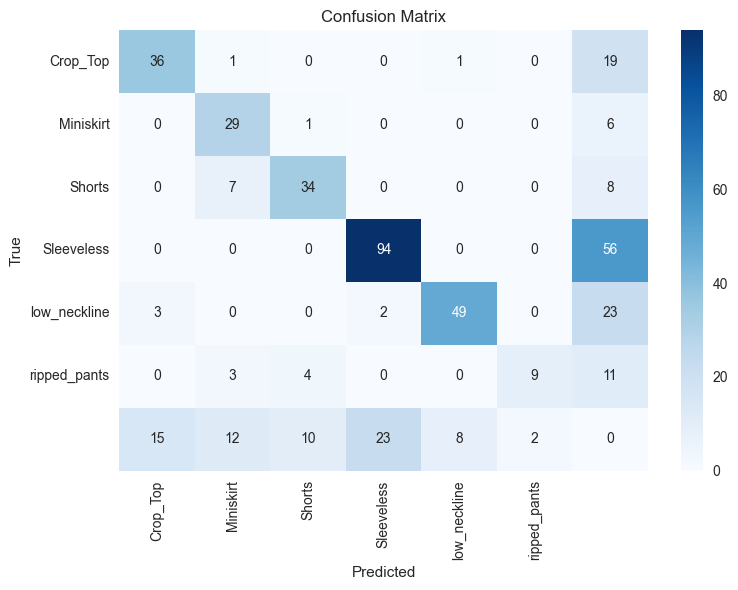


image 1/156 c:\Users\Lorcan Floran\Downloads\AI-Camera-DressCode-main_2\AI-Camera-DressCode-main\dataset\test\images\-004-2_jpg.rf.7363d8a9e0e14164622c68d73273e3fe.jpg: 640x640 (no detections), 14.5ms
image 2/156 c:\Users\Lorcan Floran\Downloads\AI-Camera-DressCode-main_2\AI-Camera-DressCode-main\dataset\test\images\-14_jpg.rf.4f5b35686179b5bdeea2211bbe4d0baa.jpg: 640x640 1 Crop_Top, 1 Shorts, 1 low_neckline, 6.6ms
image 3/156 c:\Users\Lorcan Floran\Downloads\AI-Camera-DressCode-main_2\AI-Camera-DressCode-main\dataset\test\images\-16_jpg.rf.fb25601e19c296b5afec470eca0f69e9.jpg: 640x640 1 Shorts, 2 Sleevelesss, 11.1ms
image 4/156 c:\Users\Lorcan Floran\Downloads\AI-Camera-DressCode-main_2\AI-Camera-DressCode-main\dataset\test\images\-1_jpg.rf.a01c78236d9b2001dbe7a84e417ee361.jpg: 640x640 1 Miniskirt, 7.9ms
image 5/156 c:\Users\Lorcan Floran\Downloads\AI-Camera-DressCode-main_2\AI-Camera-DressCode-main\dataset\test\images\-5_jpg.rf.d5abf736a80cbd005a557ffead607bf9.jpg: 640x640 1 Crop_To

In [25]:
import seaborn as sns
metrics = model.val(data="dataset/data.yaml", split="test", imgsz=640, batch=16, save_json=True)

print("📊 Evaluation Summary:")
print(f"Precision: {metrics.box.p.mean():.4f}")
print(f"Recall: {metrics.box.r.mean():.4f}")
print(f"mAP@0.5: {metrics.box.map50:.4f}")      # already a float
print(f"mAP@0.5:0.95: {metrics.box.map:.4f}")  # already a float


# 3. Per-class metrics
names = model.names  # id → class name
per_class_map = metrics.box.maps  # list of mAP per class

print("\nPer-class mAP@0.5:0.95:")
for i, m in enumerate(per_class_map):
    print(f"  {i} ({names[i]}): {m:.4f}")

# 4. Plot confusion matrix
if metrics.confusion_matrix is not None:
    cm = metrics.confusion_matrix.matrix.astype(int)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=names.values(), yticklabels=names.values(), cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

# 5. Run qualitative predictions on test images (optional sanity check)
results = model.predict(source="dataset/test/images", imgsz=640, save=True)
print("✅ Predictions saved to:", results[0].save_dir)